In [ ]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import comb

In [ ]:
# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))


def log_posterior(alpha, prior_mu, prior_sd, health_status, y,t,p) :
    
    return

    np.log(norm.pdf(alpha, prior_mu, prior_sd))
    + np.sum(
        np.log(
            (health_status == 1).astype(int)*(y == 0).astype(int) + (health_status == 0).astype(int)*(p)**y*(1-p)**(t-y)
            ))



In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Données
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
t = x + y                        # Total des observations

# Hyperparamètres des lois a priori
mu_alpha, sigma_alpha = 0, 2  # Pour logit(p)
mu_delta, sigma_delta = 0, 2  # Pour logit(theta)

# Initialisation des chaînes MCMC
n_iter = 5000
alpha_chain = np.zeros(n_iter)
delta_chain = np.zeros(n_iter)
p_chain = np.zeros(n_iter)
theta_chain = np.zeros(n_iter)

# Valeurs initiales
alpha_chain[0] = np.random.normal(mu_alpha, sigma_alpha)
delta_chain[0] = np.random.normal(mu_delta, sigma_delta)

# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

# Algorithme Metropolis-Hastings
for i in range(1, n_iter):
    # Propositions
    alpha_prop = np.random.normal(alpha_chain[i-1], 0.1)
    delta_prop = np.random.normal(delta_chain[i-1], 0.1)
    
    # Transformations
    p_prop = inv_logit(alpha_prop)
    theta_prop = inv_logit(delta_prop)
    
    # Calcul de la vraisemblance
    likelihood_current = np.prod(stats.binom.pmf(y, t, inv_logit(alpha_chain[i-1])))
    likelihood_proposed = np.prod(stats.binom.pmf(y, t, p_prop))
    
    # Calcul des a priori
    prior_current = stats.norm.pdf(alpha_chain[i-1], mu_alpha, sigma_alpha) * stats.norm.pdf(delta_chain[i-1], mu_delta, sigma_delta)
    prior_proposed = stats.norm.pdf(alpha_prop, mu_alpha, sigma_alpha) * stats.norm.pdf(delta_prop, mu_delta, sigma_delta)
    
    # Ratio d'acceptation
    acceptance_ratio = (likelihood_proposed * prior_proposed) / (likelihood_current * prior_current)
    
    # Acceptation ou rejet
    if np.random.rand() < min(1, acceptance_ratio):
        alpha_chain[i] = alpha_prop
        delta_chain[i] = delta_prop
    else:
        alpha_chain[i] = alpha_chain[i-1]
        delta_chain[i] = delta_chain[i-1]
    
    p_chain[i] = inv_logit(alpha_chain[i])
    theta_chain[i] = inv_logit(delta_chain[i])

# Tracé des distributions a posteriori
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(p_chain, bins=30, density=True)
plt.title("Distribution a posteriori de p")

plt.subplot(1, 2, 2)
plt.hist(theta_chain, bins=30, density=True)
plt.title("Distribution a posteriori de θ")
plt.show()

In [20]:
# Données
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
T = x + y                        # Total des observations

In [21]:
def heart_mixture_sampler(n_iter,x,y,T) : 
    # Données
    n_individual = len(x)
    
    # Variance des noyaux de propositions
    proposal_sd_alpha = 0.5
    proposal_sd_delta = 0.5

    # Hyperparamètres des lois a priori
    prior_mu_alpha, prior_sd_alpha = 0, 2  # Pour logit(p), A REVOIR COMMENT ON CHOISIT NOTRE PRIOR 
    prior_mu_delta, prior_sd_delta = 0, 2  # Pour logit(theta)

    # Initialisation des chaînes MCMC
    alpha_chain = np.zeros(n_iter)
    delta_chain = np.zeros(n_iter)
    beta_chain = np.zeros(n_iter)
    p_chain = np.zeros(n_iter)
    theta_chain = np.zeros(n_iter)
    health_status = (y == 0).astype(int) ## 1 if healthy, 0 if not
    
    beta_chain[0] = np.exp(alpha_chain[0])
    p_chain[0] = beta_chain[0] / (1 + beta_chain[0])
    theta_chain[0] = inv_logit(delta_chain[0])
    
    # On mets à jours les paramètres
    for t in range(1,n_iter) :
        # Mise à jour de alpha via Metropolis-Hastings
        alpha_prop = alpha_chain[t-1] + np.random.normal(0, proposal_sd_alpha) ### A revoir comment on choisit la variance du noyau de proposition 
        acceptance_ratio = np.exp(log_posterior(alpha_prop, prior_mu_alpha, prior_sd_alpha, health_status, y,t,p_chain[t-1]) - log_posterior(alpha_chain[t-1], prior_mu_alpha, prior_sd_alpha, health_status, y,t,p_chain[t-1]))
        if np.random.rand() < min(1, acceptance_ratio):
            alpha_chain[t] = alpha_prop 
        else:
            alpha_chain[t] = alpha_chain[t-1]
        
        # Mise à jour de delta via Metropolis-Hastings
        delta_prop = delta_chain[t-1] + np.random.normal(0, proposal_sd_delta) ### A revoir comment on choisit la variance du noyau de proposition 
        acceptance_ratio = np.exp(log_posterior(delta_prop, prior_mu_delta, prior_sd_delta, health_status, y,t,p_chain[t-1]) - log_posterior(delta_chain[t-1], prior_mu_delta, prior_sd_delta, health_status, y,t,p_chain[t-1]))
        if np.random.rand() < min(1, acceptance_ratio):
            delta_chain[t] = delta_prop 
        else:
            delta_chain[t] = delta_chain[t-1]
            
        # Mise à jour de p et theta
        beta_chain[t] = np.exp(alpha_chain[t])
        p_chain[t] = beta_chain[t] / (1 + beta_chain[t])
        theta_chain[t] = inv_logit(delta_chain[t])
        
        # Mise à jour des variables latentes 
        for i in range(n_individual):
            if y[i] > 0:
                # Pas possible d'être guéri
                health_status[i] = 0
            else:
                # On tire un Bernoulli
                numerator = theta_chain[t]
                denominator = theta_chain[t] + (1 - theta_chain[t])*( (1-p_chain[t])**T[i] )
                prob_gueri = numerator/denominator
                
                # health_status[i] = 1 si unif < prob_gueri, sinon 0
                if np.random.rand() < prob_gueri:
                    health_status[i] = 1
                else:
                    health_status[i] = 0 
        
        return alpha_chain, delta_chain, p_chain, theta_chain, health_status
        
    
    


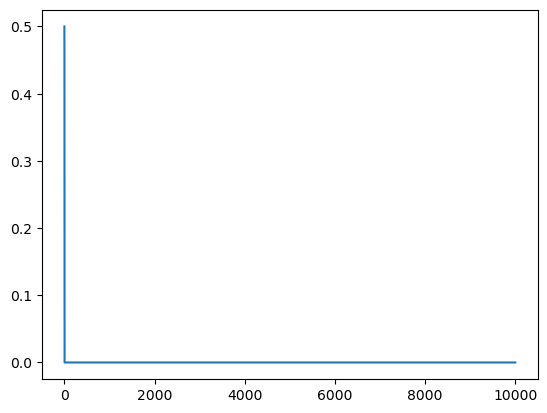

In [ ]:
alpha_chain, delta_chain, p_chain, theta_chain, health_status = heart_mixture_sampler(10000,x,y,T)

plt.plot(p_chain)